# Diffusion mean estimation
See https://arxiv.org/abs/2105.12061

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.manifolds.S2 import *
from src.manifolds.torus import *
from src.manifolds.cylinder import *
M = S2()
# M = Torus(params=(.5,1.,[0,0,1]))
# M = Cylinder()

print(M)
from src.plotting import *
#%matplotlib notebook

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


2d sphere (ellipsoid parameters [1. 1. 1.], spherical_coords: False)


In [3]:
# Riemannian structure
from src.Riemannian import metric
metric.initialize(M)

# geodesics
from src.Riemannian import geodesic
geodesic.initialize(M)

# Logarithm map
from src.Riemannian import Log
Log.initialize(M)

x = M.coords(jnp.zeros(M.dim))

using M.Exp for Logarithm


## Sample Data

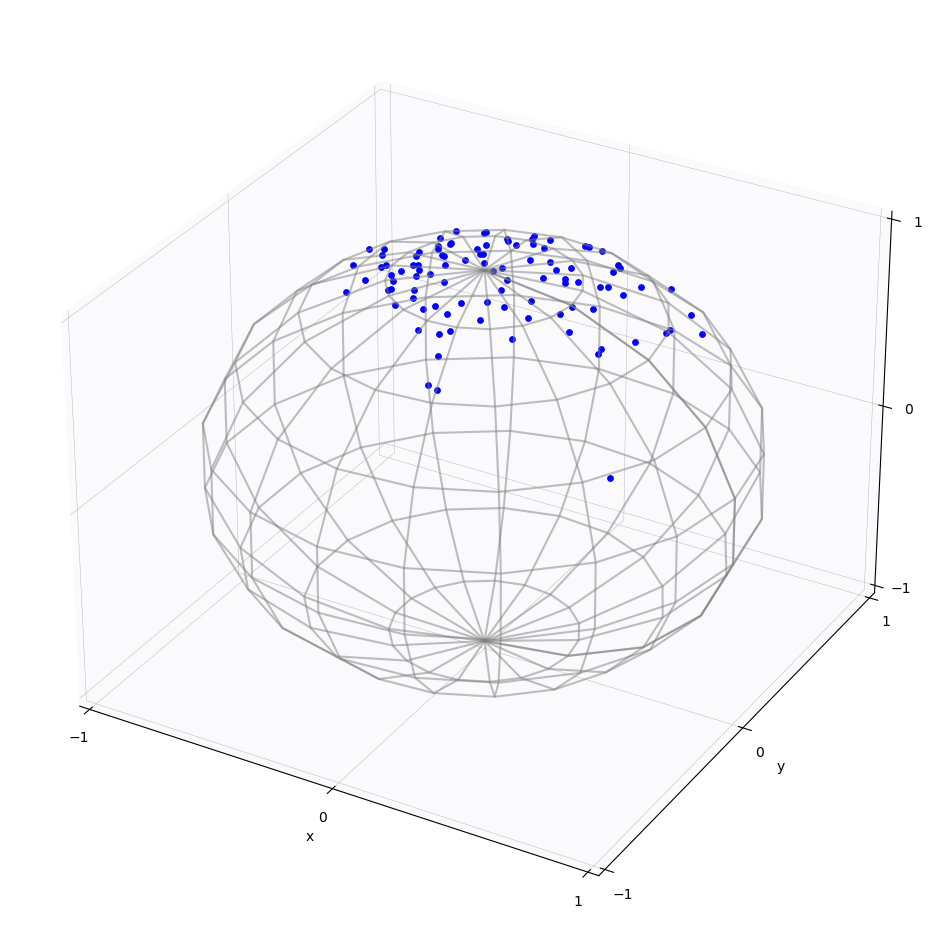

In [4]:
# coordinate form
from src.stochastics import Brownian_coords
Brownian_coords.initialize(M)

# product sde
from src.stochastics import product_sde
from src.stochastics.product_sde import tile
(product,sde_product,chart_update_product) = product_sde.initialize(M,M.sde_Brownian_coords,M.chart_update_Brownian_coords)

N = 100
_dts = dts(T=1.)
(ts,xss,chartss,*_) = product(tile(x,N),_dts,dWs(N*M.dim,_dts).reshape(-1,N,M.dim),jnp.repeat(.3,N))
samples = xss[-1]
chartss = chartss[-1]    

# plot
newfig()
M.plot()
for i in range(N):
    M.plotx((samples[i],chartss[i]))
plt.show()

## Diffusion mean estimation, bridge sampling

In [5]:
from src.statistics import diffusion_mean
diffusion_mean.initialize(M)

# run once to compile
(thetas,chart,log_likelihood,log_likelihoods,thetass) = M.diffusion_mean((samples,chartss),num_steps=2)

Step 0 | T: 4.630417e+00 | T: ((Array([ 1.3147894e-10, -1.5635655e-08], dtype=float32), Array(0.20999993, dtype=float32)), Array([ 0.03136366, -0.5449656 ,  0.8378715 ], dtype=float32))
Step 1 | T: 3.599164e+00 | T: ((Array([-0.00453529,  0.00997231], dtype=float32), Array(0.21988772, dtype=float32)), Array([ 0.03136366, -0.5449656 ,  0.8378715 ], dtype=float32))
Final 1 | T: 3.599164e+00 | T: (Array([-0.00453529,  0.00997231], dtype=float32), Array(0.21988772, dtype=float32))


Step 0 | T: 4.634199e+00 | T: ((Array([ 1.3147894e-10, -1.5635655e-08], dtype=float32), Array(0.20999993, dtype=float32)), Array([ 0.03136366, -0.5449656 ,  0.8378715 ], dtype=float32))
Step 1 | T: 3.598864e+00 | T: ((Array([-0.00452569,  0.00997227], dtype=float32), Array(0.21988729, dtype=float32)), Array([ 0.03136366, -0.5449656 ,  0.8378715 ], dtype=float32))
Step 2 | T: 2.895697e+00 | T: ((Array([-0.00434434,  0.0198681 ], dtype=float32), Array(0.22959703, dtype=float32)), Array([ 0.03136366, -0.5449656 ,  0.8378715 ], dtype=float32))
Step 3 | T: 2.313504e+00 | T: ((Array([-0.00184291,  0.02965349], dtype=float32), Array(0.23907262, dtype=float32)), Array([ 0.03136366, -0.5449656 ,  0.8378715 ], dtype=float32))
Step 4 | T: 1.830305e+00 | T: ((Array([0.0015105 , 0.03930036], dtype=float32), Array(0.24826656, dtype=float32)), Array([ 0.03136366, -0.5449656 ,  0.8378715 ], dtype=float32))
Step 5 | T: 1.430935e+00 | T: ((Array([0.00474138, 0.0487851 ], dtype=float32), Array(0.2571413,

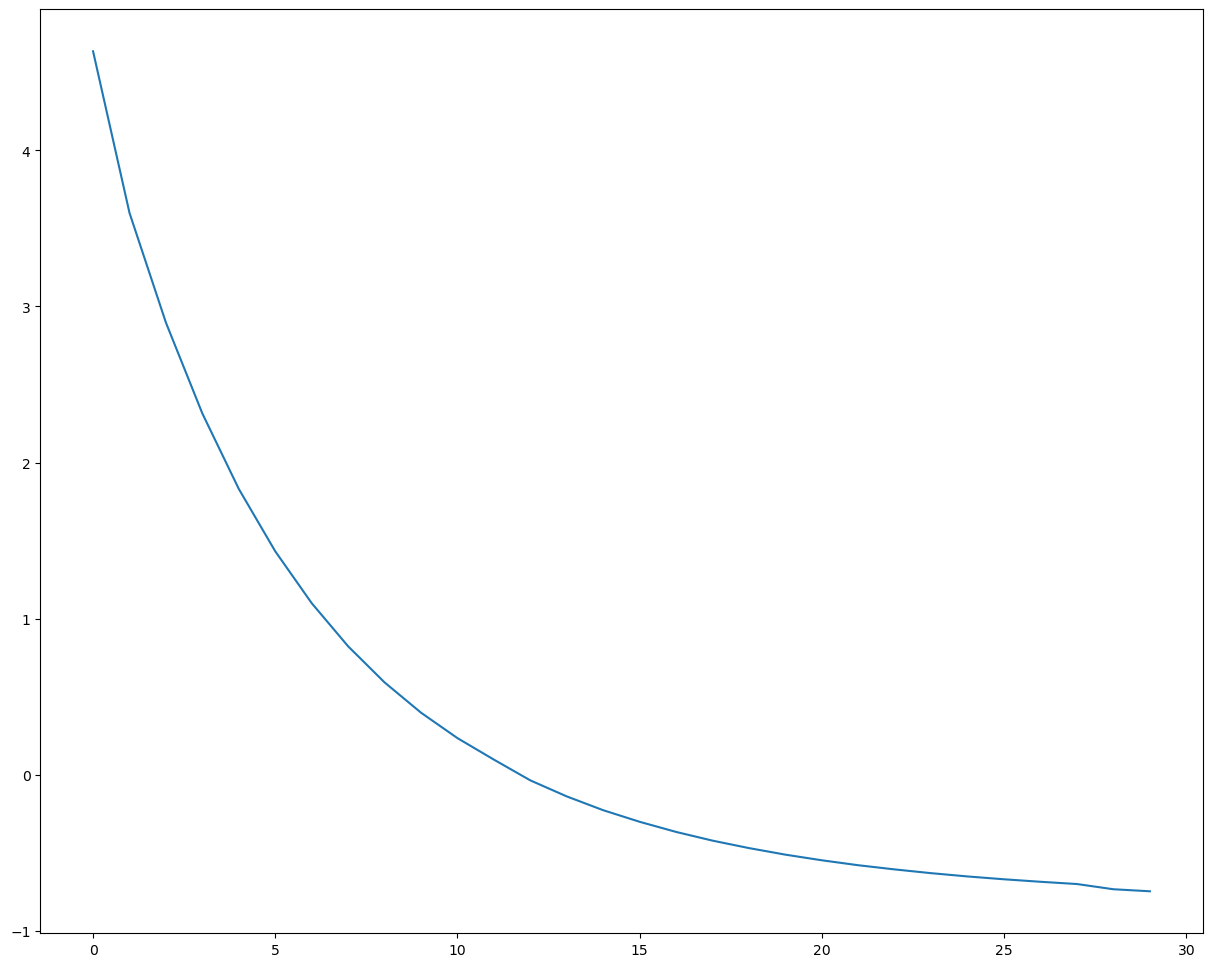

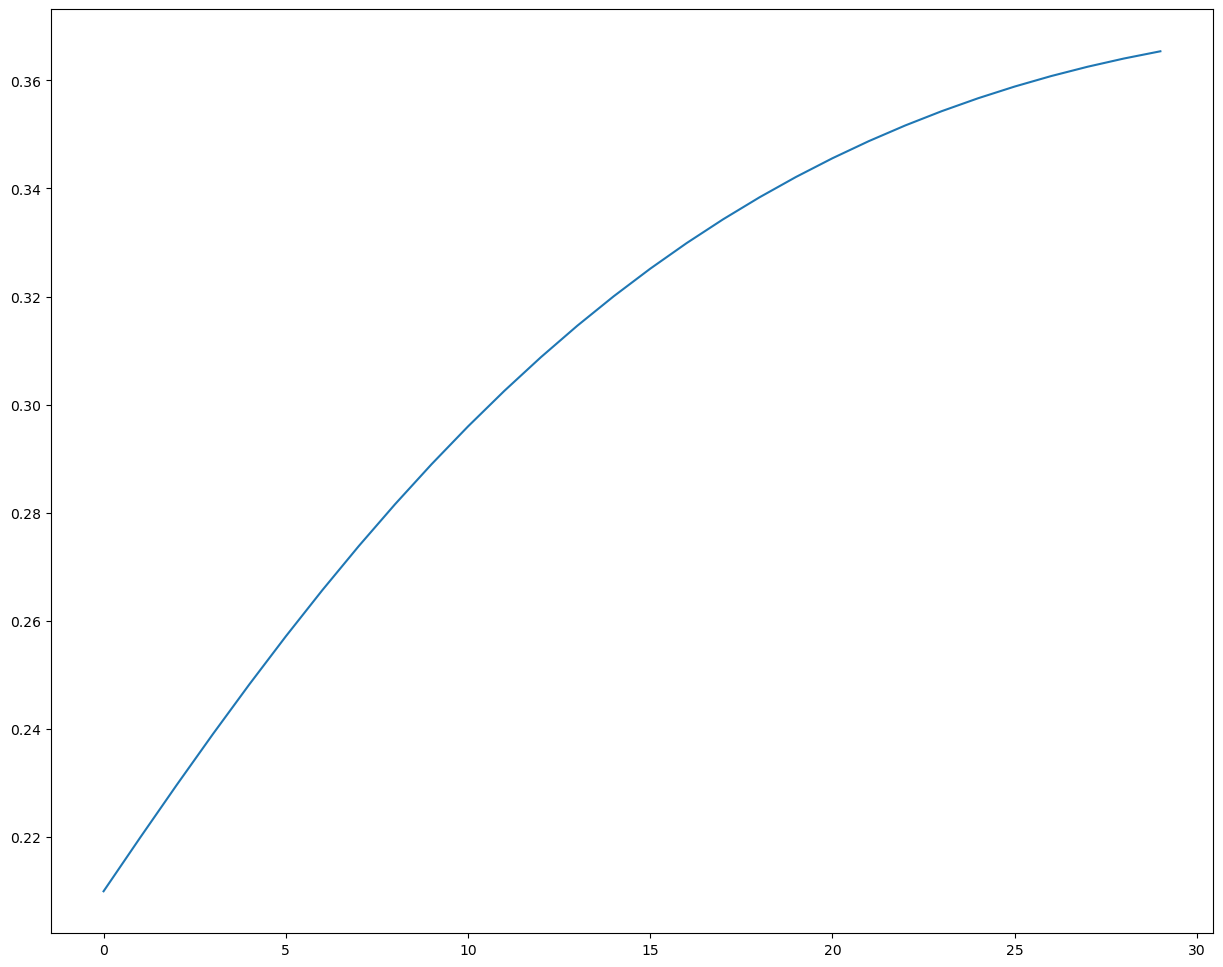

[ 0.03252902 -0.1544178   0.9874196 ]


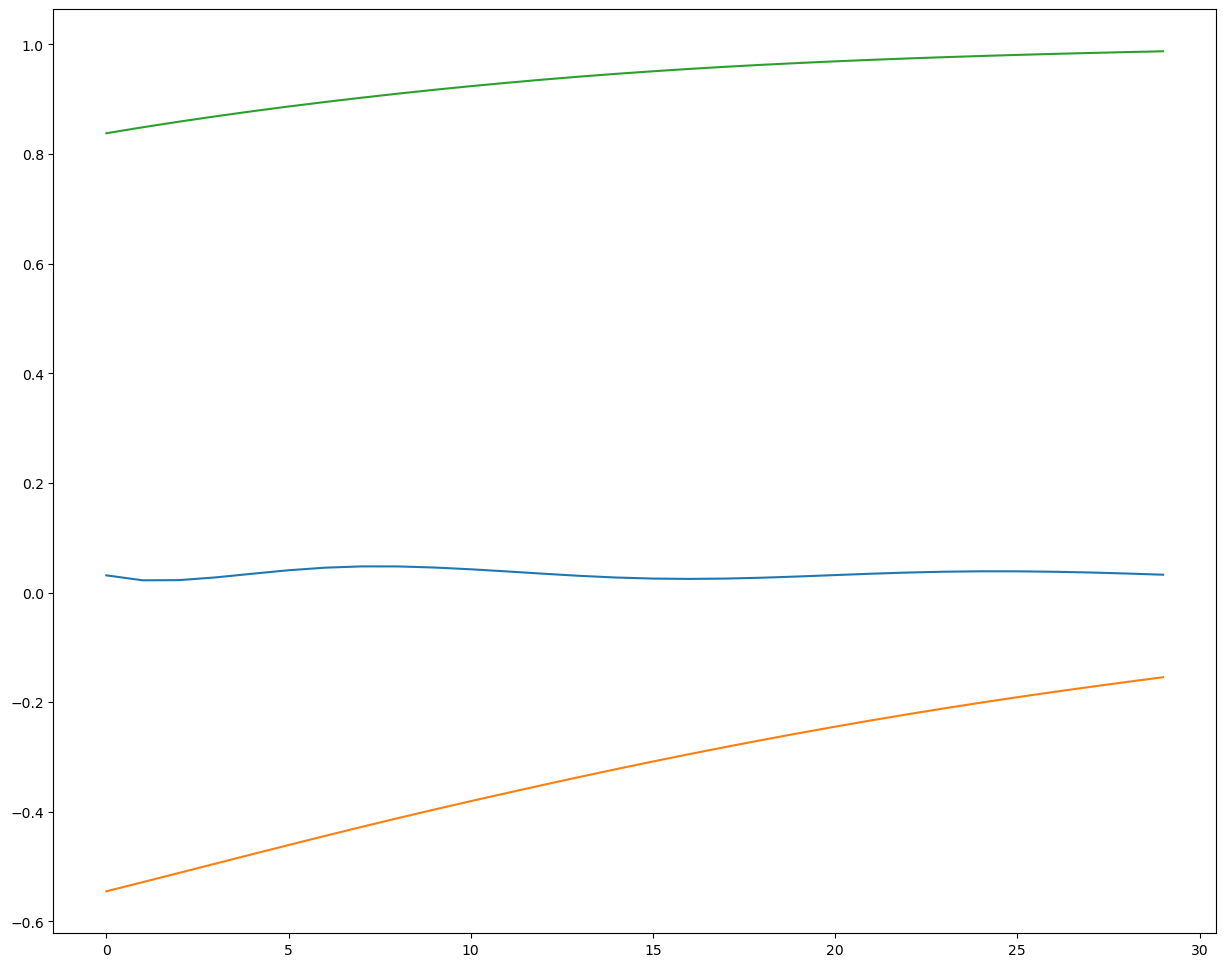

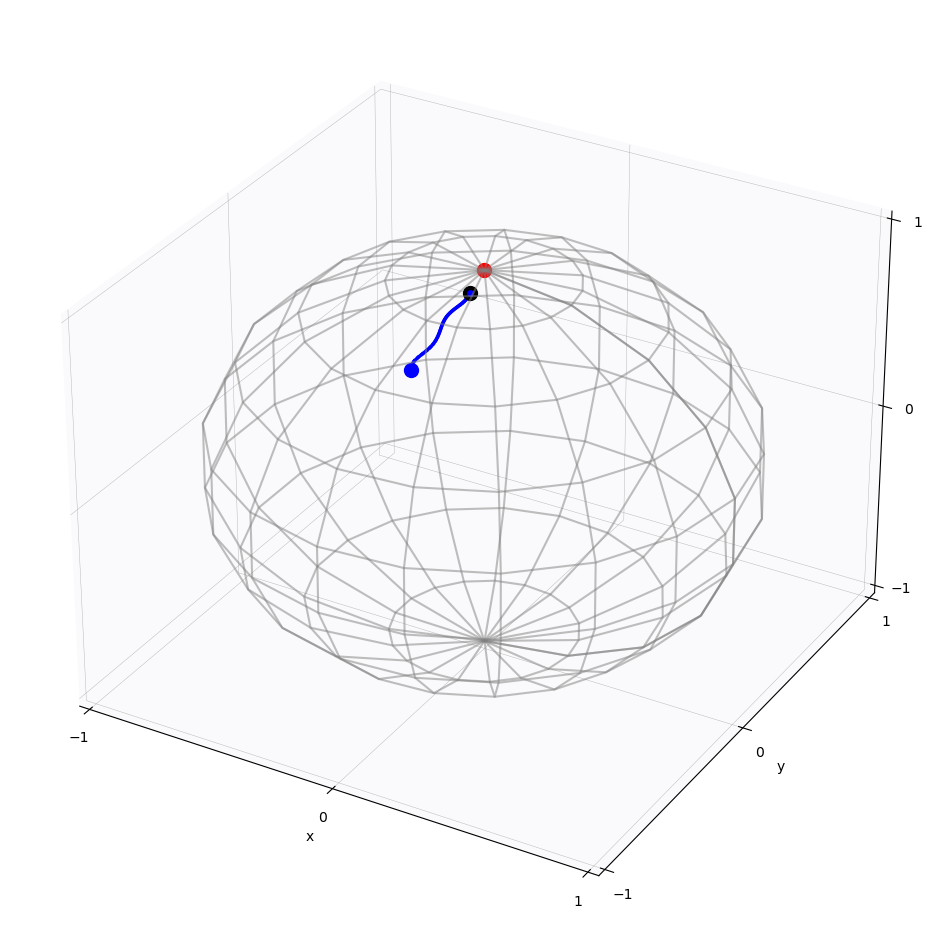

In [6]:
# run MLE
%time (thetas,chart,log_likelihood,log_likelihoods,thetass) = M.diffusion_mean((samples,chartss),num_steps=30)

# plot
n_steps = log_likelihoods.shape[0]
plt.plot(range(n_steps),log_likelihoods)
# plt.savefig('ML_likelihoods.pdf')
plt.show()
plt.plot(range(n_steps),[t[1] for t in thetass])
plt.show()
plt.plot(range(n_steps),[M.F((t[0],t[2])) for t in thetass])
print(M.F((thetas[0],chart)))
# plt.savefig('ML_thetas.pdf')
plt.show()

M.newfig()
M.plot()
M.plotx((thetas[0],chart),color='k',s=100) # result
M.plotx((thetass[0][0],thetass[0][2]),color='b',s=100) # initial point
M.plotx(x,color='r',s=100)
M.plot_path(list([(t[0],t[2]) for t in thetass]),color='b',linewidth=2.5)

# plt.savefig('MLmean_iterations.pdf')
plt.show()

## Diffusion mean estimation, diagonal sampling

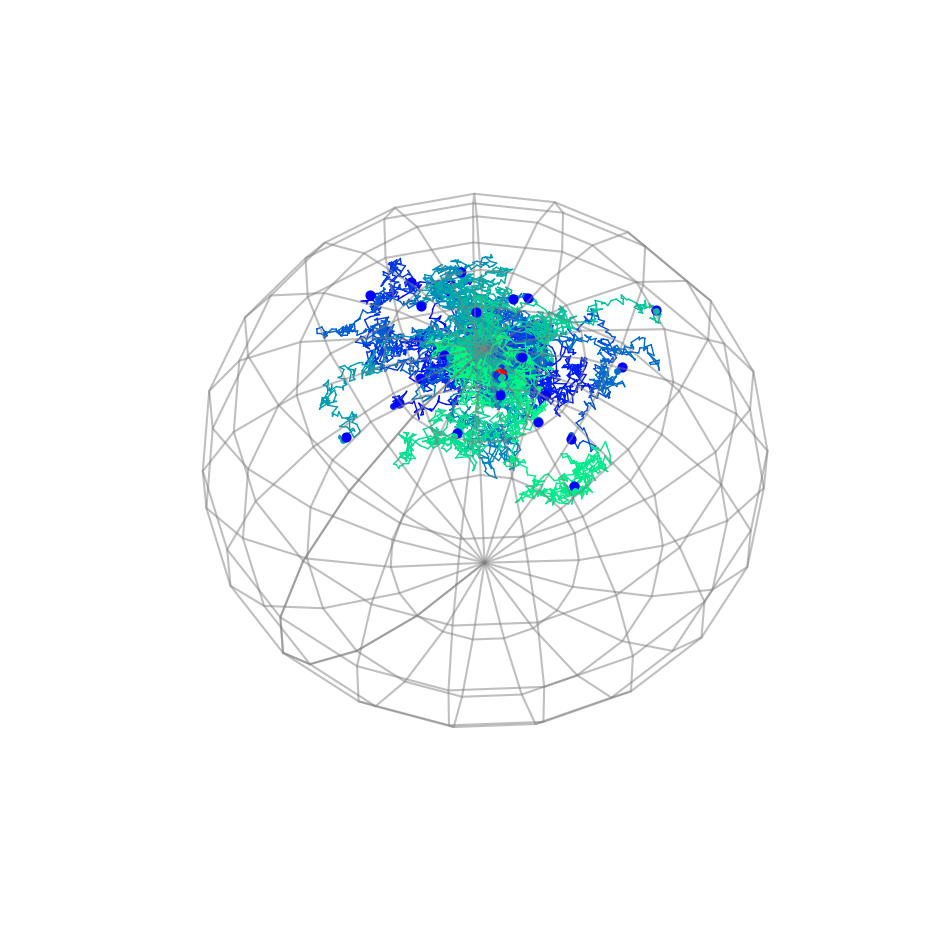

In [7]:
# # condition on diagonal of product manifold
from src.stochastics import diagonal_conditioning
diagonal_conditioning.initialize(M,sde_product,chart_update_product)

_dts = dts(n_steps=500,T=.1)
(ts,xss,_chartss) = M.diagonal((samples,chartss),
                             _dts,dWs(N*M.dim,_dts).reshape(-1,N,M.dim),x[1],jnp.repeat(1.,N))
mean = jnp.mean(jax.vmap(lambda _x,chart: M.update_coords((_x,chart),x[1])[0],0)(xss[-1],_chartss[-1]),0)

# plot
M.newfig()
M.plot()
colormap = plt.get_cmap('winter')
colors=[colormap(k) for k in np.linspace(0, 1, N)]
for i in jnp.arange(1,N,5):
    M.plot_path(zip(xss[:,i],_chartss[:,i]),color=colors[i])
    M.plotx((samples[i],chartss[i]),s=40)
M.plotx((mean,x[1]),color='r',s=80)
ax = plt.gcf().gca(); ax.view_init(60, 45) # rotate
plt.axis('off')
plt.show()

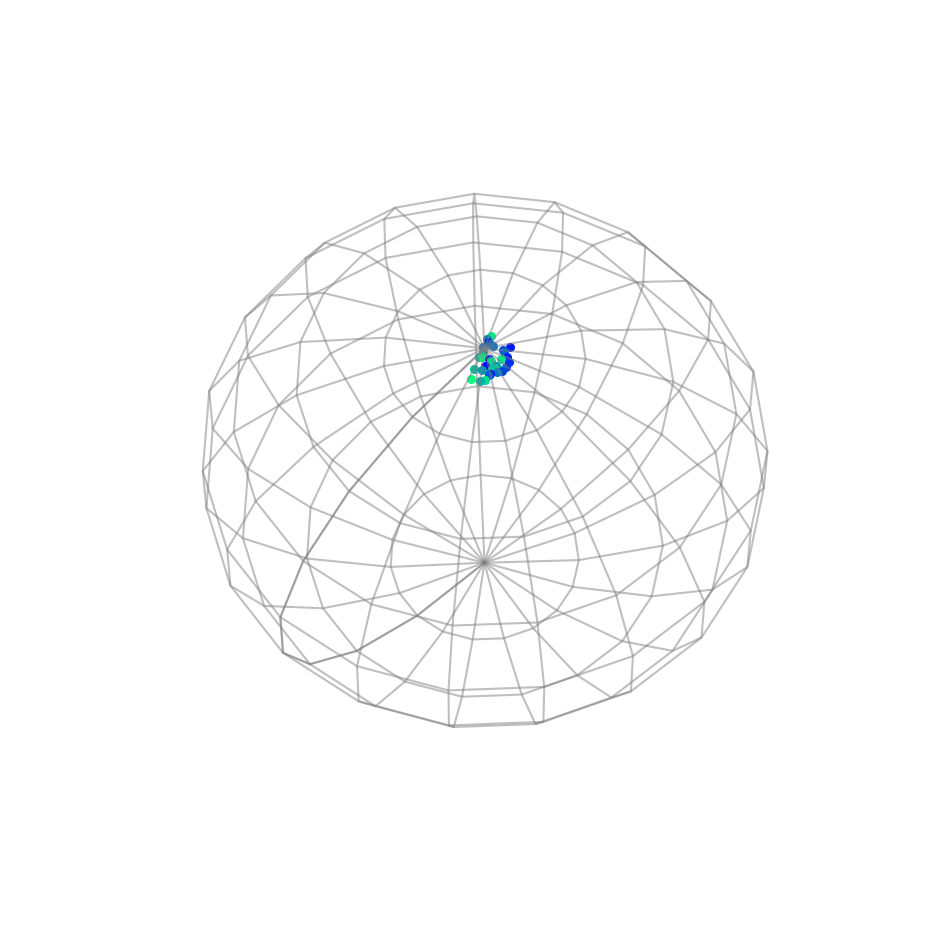

In [8]:
# sample multiple means
K = 32
means = np.zeros((K,M.dim))

_dts = dts(T=.2)
for i in range(K):
    (ts,xss,_chartss) = M.diagonal((samples,chartss),
                             _dts,dWs(N*M.dim,_dts).reshape(-1,N,M.dim),x[1],jnp.repeat(1.,N))
    means[i] = jnp.mean(jax.vmap(lambda _x,chart: M.update_coords((_x,chart),x[1])[0],0)(xss[-1],_chartss[-1]),0)
    
colormap = plt.get_cmap('winter')
colors=[colormap(k) for k in np.linspace(0, 1, K)]

# plot estimated means with std variation
M.newfig()
M.plot()
ax = plt.gca()
for j in range(K):
    M.plotx((means[j],x[1]),color=colors[j],s=30)
ax = plt.gcf().gca(); ax.view_init(60, 45) # rotate
plt.axis('off')
plt.show()

## Frechet mean

Step 0 | T: 0.000000e+00 | T: 6.670531e-01
Step 10 | T: 2.322756e-01 | T: 9.784447e-02
Step 20 | T: 1.674035e-01 | T: 2.411470e-02
Step 30 | T: 1.888065e-01 | T: 9.614755e-03
Step 40 | T: 1.748321e-01 | T: 4.852104e-03
Step 50 | T: 1.758035e-01 | T: 2.436533e-03
Step 60 | T: 1.711581e-01 | T: 9.316878e-04
Step 70 | T: 1.705334e-01 | T: 5.691474e-04
Step 80 | T: 1.732935e-01 | T: 1.573582e-04
Step 90 | T: 1.715914e-01 | T: 1.022194e-04
Step 100 | T: 1.718387e-01 | T: 9.658726e-05
Step 110 | T: 1.713901e-01 | T: 1.051257e-04
Step 120 | T: 1.703880e-01 | T: 1.666192e-04
Step 130 | T: 1.686568e-01 | T: 3.883481e-04
Step 140 | T: 1.661343e-01 | T: 1.039580e-03
Step 150 | T: 1.633941e-01 | T: 2.687430e-03
Step 160 | T: 1.608867e-01 | T: 5.540352e-03
Step 170 | T: 1.591520e-01 | T: 7.708278e-03
Step 180 | T: 1.597046e-01 | T: 8.101580e-03
Step 190 | T: 1.625133e-01 | T: 6.227021e-03
Step 199 | T: 1.892846e-01 | T: 3.117386e-03 
loss =  0.18928464
mean =  (Array([0.01152253, 0.03244008], dtype

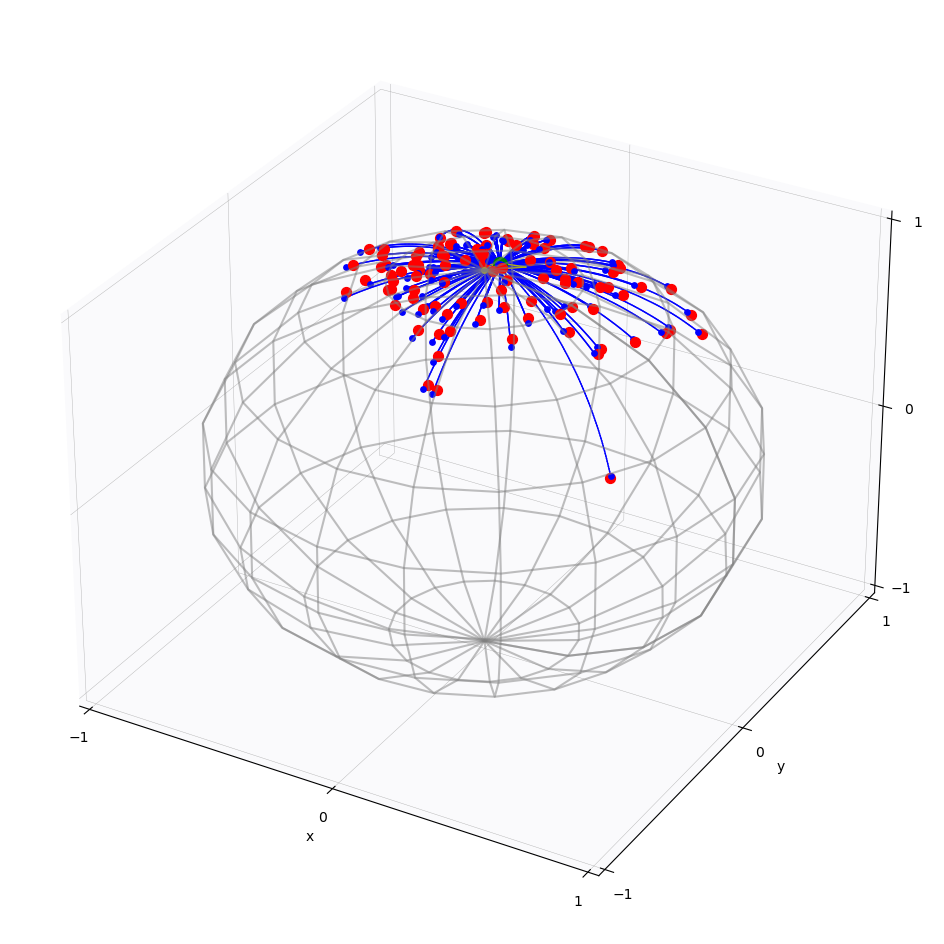

In [9]:
from src.statistics import Frechet_mean
Frechet_mean.initialize(M)

m,loss,iterations,vs = M.Frechet_mean(zip(samples,chartss),x)
# m,loss,iterations = M.Frechet_mean(zip(samples,chartss),x,Log=lambda *args: M.Log(*args))
print("loss = ", loss)
print("mean = ", m)

# plot
newfig()
M.plot()
M.plotx(m,s=100,color='g')

for i in range(len(samples)):
    try:
        (xs,charts) = M.Expt(m,vs[i])
        M.plot_path(zip(xs,charts))
    except:
        pass
    M.plotx((samples[i],chartss[i]),linewidth = 1.5, s=50, color='r')
M.plot_path(iterations,color='y')
plt.show()